In [1]:
#######################   IMPORT DEPENDENCIES   ################################
import numpy as np
import matplotlib.pyplot as plt

In [2]:
###########################  PARTICLE CLASS  ###################################
class Particle:

    def __init__(self, n=2, vmax=1, X0=None, bound=None):

        '''

        PARAMETERS:
        
        n: TOTAL DIMENSIONS
        
        vmax: MAXIMUM LIMITED VELOCITY OF A PARTICLE

        X0: INITIAL POSITION OF PARTICLE SPECIFIED BY USER

        bound: AXIS BOUND FOR EACH DIMENSION

        ################ EXAMPLE #####################
        
        If X = [x,y,z], n = 3 and if
        bound = [(-5,5),(-1,1),(0,5)]
        Then, x∈(-5,5); y∈(-1,1); z∈(0,5)

        ##############################################

        X: PARTICLE POSITION OF SHAPE (n,1)

        V: PARTICLE VELOCITY OF SHAPE (n,1)

        pbest: PARTICLE'S OWN BEST POSITION OF SHAPE (n,1)
        
        '''

        # IF INITIAL POSITION 'X0' IS NOT SPECIFIED THEN DO RANDOM INITIALIZATION OF 'X'

        if X0 is None:
            self.X = 2*np.random.rand(n,1) - 1
        else:
            self.X = np.array(X0, dtype='float64').reshape(-1,1)
        self.bound = bound
        self.n = n
        self.vmax = vmax
        
        '''

        np.random.rand() ∈ (0,1)
        
        THEREFORE 2*vmax*np.random.rand() ∈ (0,2*vmax)
        
        THUS, V = 2*vmax*np.random.rand() - vmax ∈ (-vmax,vmax)
        
        '''

        self.V = 2*vmax*np.random.rand(n,1) - vmax
        self.clip_X()

        # INITIALIZE 'pbest' WITH A COPY OF 'X' 

        self.pbest = self.X.copy()
        
    def clip_X(self):

        # IF BOUND IS SPECIFIED THEN CLIP 'X' VALUES SO THAT THEY ARE IN THE SPECIFIED RANGE
        
        if self.bound is not None:
            for i in range(self.n):
                xmin, xmax = self.bound[i]
                self.X[i,0] = np.clip(self.X[i,0], xmin, xmax)
    
    def update_velocity(self, w, c1, c2, gbest):

        '''

        PARAMETERS:

        w: INERTIA WEIGHT

        c1: INDIVIDUAL COGNITIVE PARAMETER

        c2: SOCIAL LEARNING PARAMETER

        gbest: GLOBAL BEST POSITION (BEST POSITION IN GROUP) OF SHAPE (n,1)

        ACTION:

        UPDATE THE PARTICLE'S VELOCITY
        
        '''

        self.clip_X()
        self.V = w*self.V # PARTICLE'S PREVIOUS MOTION 
        self.V += c1*np.random.rand()*(self.pbest - self.X) # COGNITIVE VELOCITY 
        self.V += c2*np.random.rand()*(gbest - self.X) # SOCIAL VELOCITY
        self.V = np.clip(self.V, -self.vmax, self.vmax) 
    
    def update_position(self):

        '''

        ACTION:
        
        UPDATE THE PARTICLE'S POSITION

        '''
        
        self.X += self.V 
        self.clip_X()

In [3]:
###########################  PSO CLASS  ####################################
class PSO:

    def __init__(self, fitness, P=30, n=2, w=0.72984, c1=2.8, c2=2.05, Tmax=300, vmax=1, X0=None, bound=None,
                update_w=False, update_c1=False, update_c2=False, update_vmax=False, plot=False, min=True, verbose=False):

        '''

        THE SYMBOLS OR NOTATIONS WERE TAKEN FROM [1] AND [2]

        PARAMETERS:

        fitness: A FUNCTION WHICH EVALUATES COST (OR THE FITNESS) VALUE

        P: POPULATION SIZE

        n: TOTAL DIMENSIONS

        w: INERTIA WEIGHT (CAN BE A CONSTANT OR CHANGES WITH ITERATION BASED ON 'update_w' VALUE)

        update_w: BOOL VALUE (TRUE WHEN 'w' CHANGES WITH ITERATION AND FALSE IF 'w' IS CONSTANT)

        c1: INDIVIDUAL COGNITIVE PARAMETER (CAN BE A CONSTANT OR CHANGES WITH ITERATION BASED ON 'update_c1' VALUE)

        update_c1: BOOL VALUE (TRUE WHEN 'c1' CHANGES WITH ITERATION AND FALSE IF 'c1' IS CONSTANT)

        c2: SOCIAL LEARNING PARAMETER (CAN BE A CONSTANT OR CHANGES WITH ITERATION BASED ON 'update_c2' VALUE)

        update_c2: BOOL VALUE (TRUE WHEN 'c2' CHANGES WITH ITERATION AND FALSE IF 'c2' IS CONSTANT)

        Tmax: MAXIMUM ITERATION

        vmax: MAXIMUM LIMITED VELOCITY OF A PARTICLE (CAN BE A CONSTANT OR CHANGES WITH ITERATION BASED ON 'update_vmax' VALUE)

        update_vmax: BOOL VALUE (TRUE WHEN 'vmax' CHANGES WITH ITERATION AND FALSE IF 'vmax' IS CONSTANT)

        X0: INITIAL POSITION OF PARTICLE SPECIFIED BY USER

        bound: AXIS BOUND FOR EACH DIMENSION

        ################ EXAMPLE #####################
        
        If X = [x,y,z], n = 3 and if
        bound = [(-5,5),(-1,1),(0,5)]
        Then, x∈(-5,5); y∈(-1,1); z∈(0,5)

        ##############################################

        plot: BOOL VALUE (TRUE IF PLOT BETWEEN GLOBAL FITNESS (OR COST) VALUE VS ITERATION IS NEEDED ELSE FALSE)

        min: BOOL VALUE (TRUE FOR 'MINIMIZATION PROBLEM' AND FALSE FOR 'MAXIMIZATION PROBLEM')

        verbose: BOOL VALUE (TRUE IF PRINTING IS REQUIRED TO SHOW GLOBAL FITNESS VALUE FOR EACH ITERATION ELSE FALSE)
        
        '''

        self.fitness = fitness
        self.P = P 
        self.n = n 
        self.w = w
        self.c1, self.c2 = c1, c2
        self.Tmax = Tmax
        self.vmax = vmax
        self.X = X0
        self.bound = bound
        self.update_w = update_w 
        self.update_c1 = update_c1
        self.update_c2 = update_c2
        self.update_vmax = update_vmax
        self.plot = plot
        self.min = min
        self.verbose = verbose
        
    def optimum(self, best, particle_x):

        '''

        PARAMETERS:

        best: EITHER LOCAL BEST SOLUTION 'pbest' OR GLOBAL BEST SOLUTION 'gbest'

        particle_x: PARTICLE POSITION

        ACTION:

        COMPARE PARTICLE'S CURRENT POSITION EITHER WITH LOCAL BEST OR GLOBAL BEST POSITIONS
        
            1. IF PROBLEM IS MINIMIZATION (min=TRUE), THEN CHECKS WHETHER FITNESS VALUE OF 'best'

            IS LESS THAN THE FITNESS VALUE OF 'particle_x' AND IF IT IS GREATER, THEN IT

            SUBSTITUTES THE CURRENT PARTICLE POSITION AS THE BEST (GLOBAL OR LOCAL) SOLUTION
            
            2. IF PROBLEM IS MAXIMIZATION (min=FALSE), THEN CHECKS WHETHER FITNESS VALUE OF 'best'

            IS GREATER THAN THE FITNESS VALUE OF 'particle_x' AND IF IT IS LESS, THEN IT

            SUBSTITUTES THE CURRENT PARTICLE POSITION AS THE BEST (GLOBAL OR LOCAL) SOLUTION
        
        '''
        
        if self.min:
            if self.fitness(best) > self.fitness(particle_x):
                best = particle_x.copy()
        else:
            if self.fitness(best) < self.fitness(particle_x):
                best = particle_x.copy()
        return best

    def initialize(self):

        '''

        PARAMETERS:

        population: A LIST OF SIZE (P,) WHICH STORES ALL THE SWARM PARTICLE OBJECT

        gbest: GLOBAL BEST POSITION (BEST POSITION IN GROUP) OF SHAPE (n,1)
        
        ACTION:

        FOR EACH PARTICLE 'i' IN SWARM POPULATION OF SIZE 'P'

            1. IT INITIALIZE POSITION 'X' AND VELOCITY 'V' OF PARTICLE 'i' AND STORES IT IN 'population' LIST

            2. INITIALIZE 'gbest' WITH COPY OF 'ith' PARTICLE'S POSITION 'X' HAVING BEST FITNESS
        
        '''
        
        self.population = []
        for i in range(self.P):
            self.population.append(Particle(n=self.n, vmax=self.vmax, X0=self.X, bound=self.bound))
            if i==0:
                self.gbest = self.population[0].X.copy()
            else:
                self.gbest = self.optimum(self.gbest, self.population[i].X)

    def update_coeff(self):
        
        '''

        ACCORDING TO THE PAPER BY M. CLERC AND J. KENNEDY [3], TO DEFINE A STANDARD FOR PARTICLE SWARM OPTIMIZATION,
        
        THE BEST STATIC PARAMETERS ARE w=0.72984 AND c1 + c2 >= 4. MORE EXACTLY c1 = 2.05 AND c2 = 2.05

        BUT ACCORDING TO [2] SOME OTHER RESEARCHERS THOUGHT THAT c1 DID NOT EQUAL c2 , AND REACHED A CONCLUSION

        c1 = 2.8 FROM EXPERIMENTS.


        BASED ON THESE IDEAS AND INSPIRED BY THE PAPER BY G. SERMPINIS [5], 
    
        [6] SUGGEST THE UPDATION OF THE COEFFICIENTS (c1 AND c2) AS CODED HERE.
        

        ADDITIONALLY, THE LINEAR DECAY OF THE PARAMETER 'w' WAS INITIALLY PROPOSED BY 

        YUHUI AND RUSS Y. H. SHI AND R. C. EBERHART [4].


        CONCEPT OF UPDATING MAXIMUM VECOLITY IS ALSO AVAILABLE IN [2]
    
        '''

        if self.update_w:
            self.w = 0.9 - 0.5*(self.t/self.Tmax)
        if self.update_c1:
            self.c1 = 3.5 - 3*(self.t/self.Tmax)
        if self.update_c2:
            self.c2 = 0.5 + 3*(self.t/self.Tmax)
        if self.update_vmax:
            self.vmax = 1.5*np.exp(1-((self.t/self.Tmax)))

    def move(self):

        '''

        PARAMETERS:

        t: ITERATION NUMBER

        fitness_time: LIST STORING FITNESS (OR COST) VALUE FOR EACH ITERATION

        time: LIST STORING ITERATION NUMBER ([0,1,2,...])

        ACTION:

        AS THE NAME SUGGESTS, THIS FUNCTION MOVES THE PARTICLES BY UPDATING THEIR

        POSITION AND VELOCITY. ALSO BASED ON THE TYPE OF PROBLEM (MAXIMIZATION OR

        MINIMIZATION), IT CALLS THE 'optimum' FUNCTION AND EVALUATE THE 'gbest'

        AND 'pbest' PARAMETERS USING FITNESS VALUE. IT ALSO UPDATE THE COEFFICIENTS.
        

        NOTE: THIS FUNCTION PRINTS THE GLOBAL FITNESS VALUE FOR EACH ITERATION

        IF THE VERBOSE IS TRUE

        FOLLOW [1] WHERE THE PSO ALGORITHM PSEUDO CODE IS PRESENT IN 'FIGURE-1'
        
        '''
        
        self.t = 0
        self.fitness_time, self.time = [], []
        while self.t <= self.Tmax:
            self.update_coeff()
            for particle in self.population:
                particle.update_velocity(self.w, self.c1, self.c2, self.gbest)
                particle.update_position()
                particle.pbest = self.optimum(particle.pbest, particle.X)
                self.gbest = self.optimum(self.gbest, particle.X)
            self.fitness_time.append(self.fitness(self.gbest))
            self.time.append(self.t)
            if self.verbose:
                print('Iteration:  ',self.t,'| best global fitness (cost):',round(self.fitness(self.gbest),7))
            self.t += 1

    def execute(self):

        '''

        A KIND OF MAIN FUNCTION 

        PRINTS THE FINAL SOLUTION

        '''
        self.initialize()
        self.move()
        print('\nOPTIMUM SOLUTION\n  >', np.round(self.gbest.reshape(-1),7).tolist())
        print('\nOPTIMUM FITNESS\n  >', np.round(self.fitness(self.gbest),7))
        print()
        if self.plot:
            self.Fplot()
        
    def Fplot(self):

        # PLOTS GLOBAL FITNESS (OR COST) VALUE VS ITERATION GRAPH
        
        plt.plot(self.time, self.fitness_time)
        plt.title('Fitness value vs Iteration')
        plt.xlabel('Iteration')
        plt.ylabel('Fitness value')
        plt.show()

In [9]:
def fitness_maximize(X):

    '''

    X: POSITION (EITHER CURRENT, LOCAL BEST OR GLOBAL BEST) OF SIZE (n,)

    EXAMPLE PRESENT IN [https://www.ece.mcmaster.ca/~xwu/part4.pdf, pg. 14] FOR 2-DIMENSIONAL VECTORS (X = (x,y))

    #################################################################################

    MAXIMIZE f(x) = 2xy + 2x - x^2 - 2y^2

    OPTIMUM SOLUTION IS x* = 2 AND y* = 1

    REPLACE 'f' BELOW WITH THIS TO TEST fitness

    f = 2*x*y + 2*x - x**2 - 2*(y**2)
    
    #################################################################################

    '''
    x, y = X[0][0], X[1][0]
    f = 2*x*y + 2*x - x**2 - 2*(y**2)
    return f

Iteration:   0 | best global fitness (cost): 1.9990874
Iteration:   1 | best global fitness (cost): 1.9990874
Iteration:   2 | best global fitness (cost): 1.9990874
Iteration:   3 | best global fitness (cost): 1.9990874
Iteration:   4 | best global fitness (cost): 1.9990874
Iteration:   5 | best global fitness (cost): 1.9998635
Iteration:   6 | best global fitness (cost): 1.9998635
Iteration:   7 | best global fitness (cost): 1.9998635
Iteration:   8 | best global fitness (cost): 1.9998635
Iteration:   9 | best global fitness (cost): 1.9998635
Iteration:   10 | best global fitness (cost): 1.9998635
Iteration:   11 | best global fitness (cost): 1.9998635
Iteration:   12 | best global fitness (cost): 1.9999703
Iteration:   13 | best global fitness (cost): 1.9999703
Iteration:   14 | best global fitness (cost): 1.9999703
Iteration:   15 | best global fitness (cost): 1.9999703
Iteration:   16 | best global fitness (cost): 1.9999703
Iteration:   17 | best global fitness (cost): 1.9999703
It

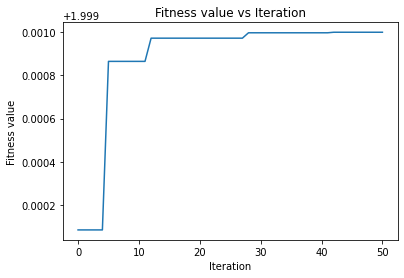

In [10]:
PSO(fitness=fitness_maximize, X0=[1,1], bound=[(-4,4),(-4,4)], min=False, Tmax=50, verbose=True, plot=True).execute()

In [11]:
######################## FITNESS FUNCTION 1 ######################################

def fitness_1(X):

    '''

    X: POSITION (EITHER CURRENT, LOCAL BEST OR GLOBAL BEST) OF SIZE (n,)

    EXAMPLE PRESENT IN [7] FOR 2-DIMENSIONAL VECTORS (X = (x,y))

    #################################################################################

    HIMMELBLAU'S FUNCTION

    MINIMIZE f(x) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2
    
    OPTIMUM SOLUTION IS x* = 3 AND y* = 2

    REPLACE 'f' BELOW WITH THIS TO TEST EXAMPLE-1

    f = (x**2 + y - 11)**2 + (x + y**2 - 7)**2

    '''

    x, y = X[0][0], X[1][0]
    f = (x**2 + y - 11)**2 + (x + y**2 - 7)**2
    return f

Iteration:   0 | best global fitness (cost): 26.0
Iteration:   1 | best global fitness (cost): 0.0097762
Iteration:   2 | best global fitness (cost): 0.0097762
Iteration:   3 | best global fitness (cost): 0.0097762
Iteration:   4 | best global fitness (cost): 0.0097762
Iteration:   5 | best global fitness (cost): 0.0097762
Iteration:   6 | best global fitness (cost): 0.0097762
Iteration:   7 | best global fitness (cost): 0.0097762
Iteration:   8 | best global fitness (cost): 0.0097762
Iteration:   9 | best global fitness (cost): 0.0097762
Iteration:   10 | best global fitness (cost): 0.0097762
Iteration:   11 | best global fitness (cost): 0.0097762
Iteration:   12 | best global fitness (cost): 0.0097762
Iteration:   13 | best global fitness (cost): 0.0097762
Iteration:   14 | best global fitness (cost): 0.0097762
Iteration:   15 | best global fitness (cost): 0.0097762
Iteration:   16 | best global fitness (cost): 0.0097762
Iteration:   17 | best global fitness (cost): 0.0097762
Iterati

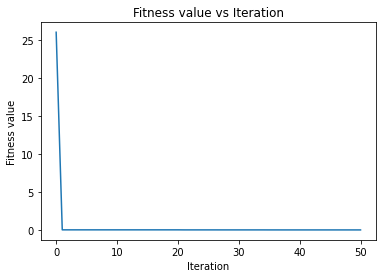

In [12]:
PSO(fitness=fitness_1, X0=[1,1], bound=[(-4,4),(-4,4)], Tmax=50, verbose=True, plot=True).execute()

In [13]:
######################## FITNESS FUNCTION 2 ######################################

def fitness_2(X):

    '''

    X: POSITION (EITHER CURRENT, LOCAL BEST OR GLOBAL BEST) OF SIZE (n,)

    EXAMPLE PRESENT IN [7] FOR 2-DIMENSIONAL VECTORS (X = (x,y))

    #################################################################################

    BOOTH'S FUNCTION

    MINIMIZE f(x) = (x + 2y - 7)^2 + (2x + y - 5)^2

    OPTIMUM SOLUTION IS x* = 1 AND y* = 3

    REPLACE 'f' BELOW WITH THIS TO TEST EXAMPLE-2

    f = (x + 2*y - 7)**2 + (2*x + y - 5)**2

    '''

    x, y = X[0][0], X[1][0]
    f = (x + 2*y - 7)**2 + (2*x + y - 5)**2
    return f

Iteration:   0 | best global fitness (cost): 1.8106868
Iteration:   1 | best global fitness (cost): 0.0358708
Iteration:   2 | best global fitness (cost): 0.0254601
Iteration:   3 | best global fitness (cost): 0.0254601
Iteration:   4 | best global fitness (cost): 0.0254601
Iteration:   5 | best global fitness (cost): 0.016744
Iteration:   6 | best global fitness (cost): 0.016744
Iteration:   7 | best global fitness (cost): 0.0066669
Iteration:   8 | best global fitness (cost): 0.0066669
Iteration:   9 | best global fitness (cost): 0.0066669
Iteration:   10 | best global fitness (cost): 0.0066669
Iteration:   11 | best global fitness (cost): 0.0066669
Iteration:   12 | best global fitness (cost): 0.0066669
Iteration:   13 | best global fitness (cost): 0.0066669
Iteration:   14 | best global fitness (cost): 0.0066669
Iteration:   15 | best global fitness (cost): 0.0009051
Iteration:   16 | best global fitness (cost): 0.0009051
Iteration:   17 | best global fitness (cost): 0.0009051
Iter

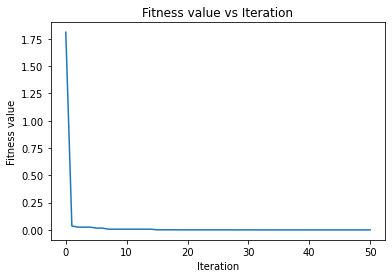

In [14]:
PSO(fitness=fitness_2, X0=[1,1], bound=[(-4,4),(-4,4)], Tmax=50, verbose=True, plot=True).execute()

In [15]:
######################## FITNESS FUNCTION 3 ######################################

def fitness_3(X):

    '''

    X: POSITION (EITHER CURRENT, LOCAL BEST OR GLOBAL BEST) OF SIZE (n,)

    EXAMPLE PRESENT IN [7] FOR 2-DIMENSIONAL VECTORS (X = (x,y))

    #################################################################################

    BEALE'S FUNCTION

    MINIMIZE f(x) = (1.5 - x - xy)^2 + (2.25 - x + xy^2)^2 + (2.625 - x + xy^3)^2

    OPTIMUM SOLUTION IS x* = 3 AND y* = 0.5

    REPLACE 'f' BELOW WITH THIS TO TEST EXAMPLE-3

    f = (1.5 - x + x*y)**2 + (2.25 - x + x*(y**2))**2 + (2.625 - x + x*(y**3))**2
    
    #################################################################################

    '''

    x, y = X[0][0], X[1][0]
    f = (1.5 - x + x*y)**2 + (2.25 - x + x*(y**2))**2 + (2.625 - x + x*(y**3))**2
    return f

Iteration:   0 | best global fitness (cost): 0.5454673
Iteration:   1 | best global fitness (cost): 0.5454673
Iteration:   2 | best global fitness (cost): 0.4021038
Iteration:   3 | best global fitness (cost): 0.1896935
Iteration:   4 | best global fitness (cost): 0.0733799
Iteration:   5 | best global fitness (cost): 0.0392113
Iteration:   6 | best global fitness (cost): 0.0392113
Iteration:   7 | best global fitness (cost): 0.0120171
Iteration:   8 | best global fitness (cost): 0.0120171
Iteration:   9 | best global fitness (cost): 0.0120171
Iteration:   10 | best global fitness (cost): 0.0120171
Iteration:   11 | best global fitness (cost): 0.0048366
Iteration:   12 | best global fitness (cost): 0.0030256
Iteration:   13 | best global fitness (cost): 0.0008454
Iteration:   14 | best global fitness (cost): 0.0008454
Iteration:   15 | best global fitness (cost): 0.0008284
Iteration:   16 | best global fitness (cost): 0.0008284
Iteration:   17 | best global fitness (cost): 0.0008284
It

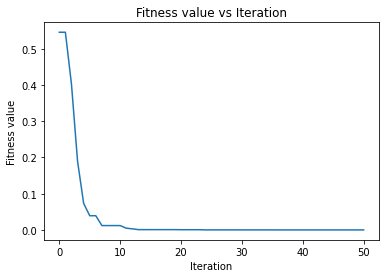

In [16]:
PSO(fitness=fitness_3, X0=[1,1], bound=[(-4,4),(-4,4)], Tmax=50, verbose=True, plot=True).execute()